### Use Python H2O.ai AutoML to build a REGRESSION model and deploy it with KNIME MOJO nodes


<img src="../KNIME_loves_h2o.png" width="600">


##### GitHub repository
https://github.com/ml-score/knime_meets_python/tree/main/machine_learning/regression


###### additional links and texts

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

https://medium.com/dataman-in-ai/the-shap-values-with-h2o-models-773a203b75e3


PLEASE note: auto-machine-learning might benefit from longer trainig time so adapt the setting "**max_runtime_secs_opts**" accoringly. To test if the notebook works these has been set to just afew minutes. You might want to let it run for several hours (or even days) depending on your task and the restults.

Also you might want to inspect the other settings about algorithms and metrics (RMSE, MAE ...)

There is also a notebook to collect and inspect the results of the models you have created The parameters will be stored in JSON files so you can collect and compare them:

**kn_example_python_h2o_automl_inspect_models.ipynb**

#### 001 - setup python libraries

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# provide a software like h2o with a java path using KNIME's own java version
# variable java.home from KNIME

# https://hub.knime.com/-/spaces/-/latest/~SGv1Cosah8BXabfa/

# KNIME Snippets (2): Unearthing Hidden Node Gems — Managing Missing Values, Row Numbers and some Quick Java and Paths
# https://medium.com/p/3c3c7acb019f

import os;

# your own Java path might look different obviously :-) - check the link and the Medium article about how to find it

# os.environ["JAVA_HOME"] = "C:\\Users\\x123456789\\software\\knime_4.6.1\\plugins\\org.knime.binary.jre.win32.x86_64_17.0.3.20220621\\jre"
# os.environ["JAVA_HOME"] = "/Applications/KNIME 4.7.1.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.aarch64_17.0.5.20230320/jre/Contents/Home"

os.environ["JAVA_HOME"] = "/Applications/KNIME 4.7.8 Intel.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.x86_64_17.0.5.20230320/jre/Contents/Home"


# /Applications/KNIME 4.7.8 Intel.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.x86_64_17.0.5.20230320/jre/Contents/Home

print("setenv JAVA_HOME", os.environ["JAVA_HOME"])

setenv JAVA_HOME /Applications/KNIME 4.7.8 Intel.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.x86_64_17.0.5.20230320/jre/Contents/Home


In [4]:
# initiate h2o
# pip uninstall h2o
# if it is already running it will cconnect to the running cluster
# # pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# conda install -c h2oai h2o

import h2o

from h2o.automl import H2OAutoML

h2o.init()

# under Windows there might be a problem with the progress bar - so you could just turn it off
# https://forum.knime.com/t/python-script-and-h2o-data-frames-error-under-windows/21099/4?u=mlauber71
# h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.5" 2022-10-18; OpenJDK Runtime Environment Temurin-17.0.5+8 (build 17.0.5+8); OpenJDK 64-Bit Server VM Temurin-17.0.5+8 (build 17.0.5+8, mixed mode, sharing)
  Starting server from /opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpi1jypzkg
  JVM stdout: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpi1jypzkg/h2o_m_lauber_started_from_python.out
  JVM stderr: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpi1jypzkg/h2o_m_lauber_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,3 months and 18 days
H2O_cluster_name:,H2O_from_python_m_lauber_q926ud
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [5]:
# the flow_variables<..> are there if you want to use the code from within KNIME
# and privide the information via (well) Flow Variables

# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "H2O_AutoML_Regression"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240226
var_timestamp_time:  1722h
var_model_name_full:  H2O_AutoML_Regression_20240226_1722h_jupyter


### Score Kaggle House Prices: Advanced Regression Techniques -  

use H2O.ai nodes and other models - measure results with RMSE

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview




In [6]:
data      = pq.read_table(var_path_data + "dataset_regression_80.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "dataset_regression_20.parquet").to_pandas()

In [7]:
excluded_features = ['row_id']
label = 'Target'  # label is a simple string

features = [feat for feat in data.columns if feat not in excluded_features and feat != label]  # change "not in" to "!="

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

# store the features plus the labels in a list
features_plus_label = features.copy()  # use copy() to prevent modifying original list
features_plus_label.append(label)  # use append() as label is a simple string

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
feature plus Label columns: {features_plus_label}
rest columns: {rest_cols}''')


data shape:          (1183, 80)
data[features] shape: (1183, 79)
categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Tot

In [8]:
print(data.dtypes)

MSSubClass         int32
MSZoning          object
LotFrontage      float64
LotArea            int32
Street            object
                  ...   
MoSold             int32
YrSold             int32
SaleType          object
SaleCondition     object
Target             int32
Length: 80, dtype: object


In [9]:
print(features_plus_label)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [10]:
data[cat_cols] = data[cat_cols].astype('category')

In [11]:
# split test and training data
train_df, valid_df = train_test_split(data[features_plus_label], test_size=0.3, random_state=42)

In [12]:
# import the df data into H2O data system
train = h2o.H2OFrame(train_df.copy())
valid = h2o.H2OFrame(valid_df.copy())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html

# Run AutoML for 60 seconds or
# 300 = 5 min, 600 = 10 min, 900 = 15 min, 1800 = 30 min, 3600 = 1 hour, 
# 7200 = 2 hours
# 14400 = 4 hours
# 16200 = 4.5 hours
# 18000 = 5 Stunden
# 21600 = 6 hours
# 25200 = 7 hours
# 28800 = 8 hours
# 36000 = 10 hours

# _edit: get the maximum runtime from the KNIME workflow
max_runtime_secs_opts = 120

import time
import datetime as dt
from datetime import date

var_now = dt.datetime.now()

var_startmodel_day = "{}".format(var_now.strftime("%Y%m%d"))
print("var_startmodel_day: ", var_timestamp_day)
var_startmodel_time = "{}h".format(var_now.strftime("%H%M"))
print("var_startmodel_time: ", var_timestamp_time)

# based on the set runtime print the end time
v_endtime = var_now + dt.timedelta(seconds=max_runtime_secs_opts)

var_endmodel_day = "{}".format(v_endtime.strftime("%Y%m%d"))
print("var_endmodel_day: ", var_endmodel_day)
var_endmodel_time = "{}h".format(v_endtime.strftime("%H%M"))
print("var_endmodel_time: ", var_endmodel_time)

# you could exclude algorithms as they might not be suitable eg. for export as MOJO files
# or to be used in Big Data environments
# exclude_algos      =["GBM", "GLM", "DeepLearning", "DRF", "StackedEnsemble", "XGBoost"]

# For binomial classification choose between "AUC", "logloss", "mean_per_class_error", "RMSE", "MSE". 
# For multinomial classification choose between "mean_per_class_error", "logloss", "RMSE", "MSE". 
# For regression choose between "deviance", "RMSE", "MSE", "MAE", "RMLSE".

aml = H2OAutoML(max_runtime_secs  = max_runtime_secs_opts, 
                seed               =1234, 
                sort_metric        ="RMSE",
                stopping_metric    ="RMSE",
                stopping_tolerance =0.01,
                stopping_rounds    =25,
                project_name       =var_model_name_full ,
                # exclude_algos      =["GBM", "GLM", "DeepLearning", "DRF", "StackedEnsemble"]  #,
                # exclude_algos      =["DRF", "GLM"] 
                # exclude_algos      =["DeepLearning", "StackedEnsemble", "XGBoost"] 
                exclude_algos      =["StackedEnsemble", "DeepLearning"] 
               )

# x - all our variables we want to use to explain the:
# y - Target Variable - in this case "Target"
aml.train(x = features, y = label,  
          training_frame   = train,  
          validation_frame = valid)  

var_startmodel_day:  20240226
var_startmodel_time:  1722h
var_endmodel_day:  20240226
var_endmodel_time:  1732h
AutoML progress: |
17:25:56.587: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
17:25:56.591: Stopping tolerance set by the user is < 70% of the recommended default of 0.034752402342845795, so models may take a long time to converge or may not converge at all.
17:30:50.502: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
17:30:50.502: Stopping tolerance set by the user is < 70% of the recommended default of 0.034752402342845795, so models may take a long time to 

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20240226_172556_model_1


Status of Neuron Layers: predicting Target, regression, gaussian distribution, Quadratic loss, 33.801 weights/biases, 417,7 KB, 173.880 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate            rate_rms               momentum    mean_weight            weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  -------------------  ---------------------  ----------  ---------------------  -------------------  ---------------------  -----------------------
    1        336      Input             15.0
    2        100      RectifierDropout  50.0       0.0   0.0   0.14674957641169906  0.3535667657852173     0.0         -0.004435881458588776  0.06937500834465027  0.39908075792683995    0.037333667278289795
    3        1        Linear                       0.0   0.0   0.00069317118221079  0.0005749349948018789  0.0         0.005615683831274509   0.09745800495147705  -0.024475788309508882  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 203137834.53608933
RMSE: 14252.64307193895
MAE: 9253.90391985786
RMSLE: 0.07703972244580162
Mean Residual Deviance: 203137834.53608933

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 3873723110.876107
RMSE: 62239.24092464582
MAE: 17793.73376373922
RMSLE: 0.16619106283363025
Mean Residual Deviance: 3873723110.876107

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 524265797.6036741
RMSE: 22896.85125958751
MAE: 14693.155900840287
RMSLE: 0.1334835711227867
Mean Residual Deviance: 524265797.6036741

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     15274.4      2135.62      15954.7       13062.5       18531.8       13783.6       15039.5
mean_residual_deviance  5.88319e+08  1.82492e+08  6.1948e+08    4.31069e+08   8.77341e+08   4.33685e+08   5.80017e+08
mse                     5.88319e+08  1.82492e+08  6.1948e+08    4.31069e+08   8.77341e+08   4.33685e+08   5.80017e+08
r2                      0.908521     0.0299785    0.919534      0.934916      0.857122      0.91121       0.919824
residual_deviance       5.88319e+08  1.82492e+08  6.1948e+08    4.31069e+08   8.77341e+08   4.33685e+08   5.80017e+08
rmse                    24036        3637.94      24889.4       20762.2       29619.9       20825.1       24083.5
rmsle                   0.1356       0.019143     0.11812       0.164197      0.136544      0.117976      0.141165

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2024-02-26 17:27:51  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2024-02-26 17:27:51  6.055 sec   70169 obs/sec     10        1             8280       26048.4          6.78521e+08          16105.7         0.896284       43757.7            1.91473e+09            20035.9           0.711551
    2024-02-26 17:27:52  7.346 sec   124913 obs/sec    210       21            173880     14252.6          2.03138e+08          9253.9          0.968949       6223

In [16]:
# View the AutoML Leaderboard
lb = aml.leaderboard
tb_leaderboard = lb.as_data_frame(use_pandas=True, header=True)
print(lb)

model_id                                                 rmse          mse      mae       rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20240226_172556_model_1  22896.9  5.24266e+08  14693.2    0.133484               5.24266e+08
DeepLearning_grid_1_AutoML_1_20240226_172556_model_3  24329.2  5.9191e+08   16447.8    0.150945               5.9191e+08
GBM_grid_1_AutoML_1_20240226_172556_model_4           24996    6.248e+08    16227.4    0.128211               6.248e+08
GBM_grid_2_AutoML_2_20240226_173050_model_4           24996    6.248e+08    16227.4    0.128211               6.248e+08
DeepLearning_grid_1_AutoML_1_20240226_172556_model_2  25313.5  6.40774e+08  17269    nan                      6.40774e+08
GBM_grid_1_AutoML_1_20240226_172556_model_5           25542.5  6.52421e+08  16429.7    0.130556               6.52421e+08
GBM_grid_2_AutoML_2_20240226_173050_model_5           25542.5  6.52421e+08  16429.7    0.130556               6.52421e+08
GBM_grid_1_AutoML_1_20240226_

In [17]:
# you can change the automatic choice and name a variable from the leader board
# var_selected_model = "GBM_1_AutoML_20191214_123545"
var_selected_model = aml.leader.model_id
print("var_selected_model :", var_selected_model)

# flow_variables['var_selected_model'] = var_selected_model

# get the extracted model
best_model = h2o.get_model(var_selected_model)
best_params = best_model.actual_params

var_selected_model : DeepLearning_grid_1_AutoML_1_20240226_172556_model_1


In [18]:
# show the best parameters
print(best_params)

{'model_id': 'DeepLearning_grid_1_AutoML_1_20240226_172556_model_1', 'training_frame': 'AutoML_1_20240226_172556_training_Key_Frame__upload_abc2dbb1d7527aed26df95a689a242f6.hex', 'validation_frame': 'Key_Frame__upload_a834149e0e4ba4d1e02f83c60b834284.hex', 'nfolds': 5, 'keep_cross_validation_models': False, 'keep_cross_validation_predictions': True, 'keep_cross_validation_fold_assignment': False, 'fold_assignment': 'Modulo', 'fold_column': None, 'response_column': 'Target', 'ignored_columns': [], 'ignore_const_cols': True, 'score_each_iteration': False, 'weights_column': None, 'offset_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'checkpoint': None, 'pretrained_autoencoder': None, 'overwrite_with_best_model': False, 'use_all_factor_levels': True, 'standardize': True, 'activation': 'RectifierWithDropout', 'hidden': [100], 'epochs': 204.9369532428356, 'train_samples_per_iteration': -2, 'target_rati

In [28]:
# Predict using the best model
# Ensure that 'predict' method returns a DataFrame with a single column of predictions
y_pred_df = best_model.predict(valid)
y_pred_df.head()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict
193188
125327
1.21599e+06
142219
165224
141946
305619
99828.6
154555
111191


In [30]:
# Make predictions with the best model
y_pred_h2o = best_model.predict(valid)

# Convert the H2OFrame to a pandas DataFrame for easier manipulation
predicted_values = y_pred_h2o.as_data_frame()

# If the predictions are in a column named 'predict', select it
# This step is necessary because H2O might return a DataFrame with more than one column
predicted_values = predicted_values['predict'] if 'predict' in predicted_values else predicted_values.squeeze()

# Ensure actual_values is a pandas Series or numpy array
# Convert valid[label] to a pandas Series if it's an H2OFrame
actual_values = valid[label] if isinstance(valid[label], pd.Series) else valid[label].as_data_frame().squeeze()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f'Test RMSE: {rmse:.4f}')

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Test MAE: {mae:.4f}')

r2 = r2_score(actual_values, predicted_values)
print(f'R² Score: {r2:.4f}')



deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Test RMSE: 62239.2409
Test MAE: 17793.7338


In [25]:
# save the model as MOJO which you could read back in with KNIME
var_mojo_file_name = var_path_model + var_model_name_full + "_model_stored.zip"
# flow_variables['var_mojo_file_name'] = var_mojo_file_name
print("var_mojo_file_name: ", var_mojo_file_name)

# reload the saved MOJO model
best_model.download_mojo(var_mojo_file_name)

var_mojo_file_name:  ../model/H2O_AutoML_Regression_20240226_1722h_jupyter_model_stored.zip


'/Users/m_lauber/Dropbox/knime-workspace/Machine_Learning/ml_regression/kn_example_ml_regression_py_xgboost/data/model/H2O_AutoML_Regression_20240226_1722h_jupyter_model_stored.zip'

In [64]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_RMSE": f'{rmse:.5f}',
    "Test_MAE": f'{mae:.5f}',
    "TestR_2": f'{r2:.5f}'
}

In [32]:
print(v_variable_list)

{'var_model_name': 'H2O_AutoML_Regression', 'var_model_name_full': 'H2O_AutoML_Regression_20240226_1722h_jupyter', 'num_cols': ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], 'cat_cols': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',

In [33]:
type(v_variable_list)

dict

In [34]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [35]:
# show the best parameters
best_parameters = best_model.params
print(best_parameters)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'DeepLearning_grid_1_AutoML_1_20240226_172556_model_1', 'type': 'Key<Model>', 'URL': '/3/Models/DeepLearning_grid_1_AutoML_1_20240226_172556_model_1'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240226_172556_training_Key_Frame__upload_abc2dbb1d7527aed26df95a689a242f6.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240226_172556_training_Key_Frame__upload_abc2dbb1d7527aed26df95a689a242f6.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240226_172556_training_Key_Frame__upload_abc2dbb1d7527aed26df95a689a242f6.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240226_172556_training_Key_Frame__upload_abc2dbb1d7527aed26df95a689a2

In [38]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_parameters, file=file)

In [39]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["lgbm_parameters"])

In [40]:
df_best_parameters.head()

,lgbm_parameters
0,"{'model_id': {'default': None, 'actual': {'__m..."


In [41]:
# extract important tables from model to store later
feature_imp = best_model._model_json['output']['variable_importances'].as_data_frame()

In [42]:
feature_imp.head(25)

,variable,relative_importance,scaled_importance,percentage
0,Neighborhood.Crawfor,1.000000,1.000000,0.005066
1,KitchenQual.TA,0.981104,0.981104,0.004970
2,GrLivArea,0.966446,0.966446,0.004896
3,Neighborhood.NAmes,0.945429,0.945429,0.004789
4,OverallCond,0.929022,0.929022,0.004706
5,KitchenQual.Ex,0.917220,0.917220,0.004646
6,BsmtExposure.Gd,0.911041,0.911041,0.004615
7,Exterior1st.BrkFace,0.883774,0.883774,0.004477
8,Neighborhood.StoneBr,0.883624,0.883624,0.004476
9,BsmtExposure.No,0.870532,0.870532,0.004410


In [43]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

### 1. Residual Plots

A residual plot shows the difference (or residual) between observed and predicted values. It's a good way to visualize the model's performance across different ranges of predicted values. A well-performing model would have residuals randomly scattered around zero, indicating that the model's predictions are unbiased at different levels of the response variable.

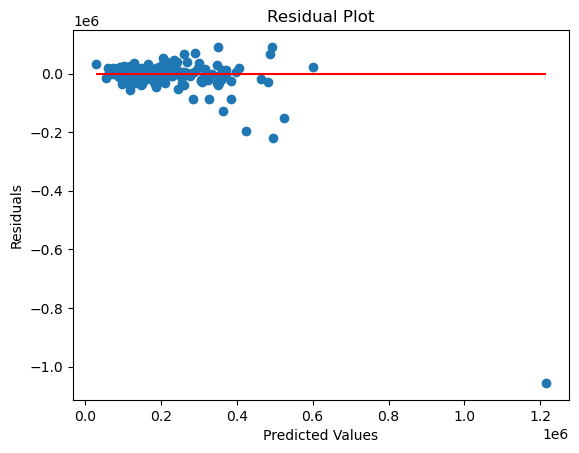

In [45]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = actual_values - predicted_values

# Plot
plt.scatter(predicted_values, residuals)
plt.hlines(y=0, xmin=predicted_values.min(), xmax=predicted_values.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


### 2. Prediction Error Plot
   
A prediction error plot shows the actual values against the predicted values. A 45-degree line is often plotted as a reference; the closer the points are to this line, the better the predictions.

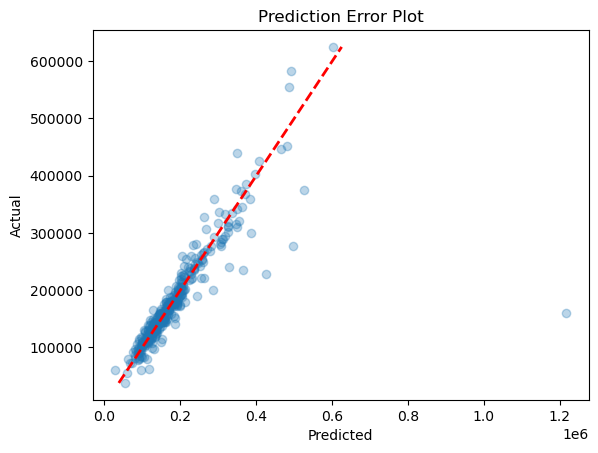

In [46]:
plt.scatter(predicted_values, actual_values, alpha=0.3)
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], '--r', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Prediction Error Plot')
plt.show()


### 3. Quantile Plots for Error Distribution
 
Quantile plots (or Q-Q plots) can be used to assess how the distribution of residuals compares to a normal distribution, which can help in understanding if the assumption of normality in errors (a common assumption in many regression models) holds.

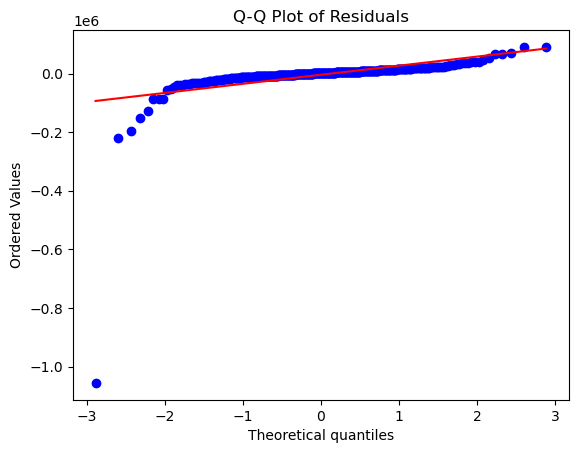

In [47]:
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


### 4. R² Score
 
While not a plot, the R² score (coefficient of determination) provides a measure of how well future samples are likely to be predicted by the model. The closer to 1, the better the model explains the variability of the response variable.

In [51]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_values, predicted_values)
print(f'R² Score: {r2:.4f}')


R² Score: 0.4164


## Apply the H2O.ai model with all the settings

this is to test if the model would actually work :-)

In [52]:
saved_mojo_model = h2o.import_mojo(var_path_model + var_model_name_full + "_model_stored.zip")

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [53]:
# re-import the stored features and column informations from the JSON file

import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [54]:
# in a real world scenario here you woudl provide the new data you want to score
# here we just use the test data from above

df_apply = h2o.H2OFrame(data_test.copy())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
# the prediction on the validation dataset will be brought back to KNIME
predictions_df = saved_mojo_model.predict(df_apply).as_data_frame()

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: ["ImStucc"]
  warnings.warn(w)
/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Condition2' has levels not trained on: ["Artery"]
  warnings.warn(w)
/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'HeatingQC' has levels not trained on: ["Po"]
  warnings.warn(w)


In [58]:
predictions_df.head()

,predict
0,223045.951132
1,133074.832490
2,122235.800106
3,125026.086419
4,364835.488919


In [59]:
result = pd.concat([df_apply.as_data_frame(), predictions_df], axis=1)

In [60]:
result.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target,predict
0,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,223045.951132
1,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,133074.832490
2,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,1,2008,WD,Normal,118000,122235.800106
3,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,GdPrv,NaN,0,7,2007,WD,Normal,132000,125026.086419
4,60,RL,101.0,14215,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,11,2006,New,Partial,325300,364835.488919
